In [2]:
from IPython import get_ipython;   
get_ipython().magic('reset -sf')

import os
os.chdir("C:/Users/Lenovo 4/Desktop/Data Quest Folder/Random Forest/")
os.getcwd()

import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
import math as math

df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Make a histogram of the cnt column of bike_rentals, and take a look at the distribution of total rentals.


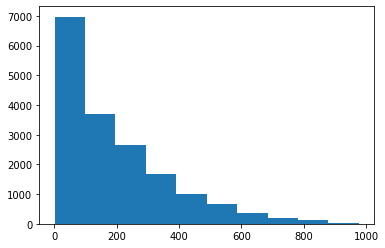

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

In [3]:
plt.hist(df["cnt"])
plt.show()
df.cnt.describe()

In [8]:
# Use the corr method on the bike_rentals dataframe to explore how each column is correlated with cnt.
corrmat = df.corr()["cnt"]
print(corrmat)

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


Variables "casual" and "registrered" seems to be highly correlated. Consider dropping these variables.


In [9]:
#use a function to re-categorize observations in "hr"  
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3
df["time_label"] = df["hr"].apply(assign_label)   

In [10]:
# 80 /20 split 
# Shuffle the rows  
# This permutes the index randomly using numpy.random.permutation
# Then, it reindexes the dataframe with the result
# The net effect is to put the rows into random order
np.random.seed(1)
df = df.reindex(np.random.permutation(df.index))
row = math.floor(df.shape[0]*.8)

train = df.iloc[:row]
test = df.iloc[row:]

In [11]:
#Model 1: Linear Regression
#Many columns are correlated with "cnt" variable 
# linear regression works best when predictors are linearly correlated to the target and also independent
# linear regression is fairly resistant to overfitting, prone to underfitting, and may not be a good model overall
from sklearn.linear_model import LinearRegression

predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

reg1 = LinearRegression()
reg1.fit(train[predictors], train["cnt"])
predictions = reg1.predict(test[predictors])

In [17]:
## MSE 
# We will use sklearn's package to calculate error metrics, but they can be coded too, as shown below.
# numpy.mean((predictions - test["cnt"]) ** 2)
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test["cnt"], predictions)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

17052.124871247568
130.5837848710458


In [20]:
# Model 2: Decision Trees 
# Decision trees tend to overfit, so adjusting parameters are essential 
# Decision trees suffer from instability: small changes in input data can result in a different output model
from sklearn.tree import DecisionTreeRegressor

# max_depth - Globally restricts how deep the tree can go
# min_samples_split - The minimum number of rows a node should have before it can be split; if this is set to 2, for example, then nodes with 2 rows won't be split, and will become leaves instead
# min_samples_leaf - The minimum number of rows a leaf must have
# min_weight_fraction_leaf - The fraction of input rows a leaf must have
# max_leaf_nodes - The maximum number of total leaves; this will cap the count of leaf nodes as the tree is being built
reg2 = DecisionTreeRegressor(min_samples_leaf=5)
# fit the tree
reg2.fit(train[predictors], train["cnt"])

predictions2 = reg2.predict(test[predictors])

# MSE  
mse = mean_squared_error(test["cnt"], predictions2)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

2731.2018678794934
52.26090190457388


 drasticallly reduced mse, decision trees take into account the non-linear predictors that are in our dataset


# Model 3: Random Forests 
# Ensembles combine the predictions of multiple models to create a more accurate final prediction. 
# Bagging and random feature subsets are integrated in the Random Forest Regressor 

In [22]:
from sklearn.ensemble import RandomForestRegressor 
# We instantiate a "RandomForestRegressor" by passing in paramteres that apply to individual trees:
# min_samples_leaf =5 The minimum number of rows a leaf must have
# We can also apply parameters specific to the random forest that alter its overall construction:
# n_estimators =5, indicates how many trees to build, has diminishing returns as it goes higher, it takes longer as well 
# boostrap = default is TRUE 
reg3 = RandomForestRegressor(n_estimators= 100, min_samples_leaf =5, random_state = 1)
reg3.fit(train[predictors],train["cnt"])
predictions3 = reg3.predict(test[predictors])
predictions_train_3 = reg3.predict(train[predictors])


In [23]:
# MSE
mse_train = mean_squared_error(train["cnt"], predictions_train_3)
print(mse_train)
mse = mean_squared_error(test["cnt"], predictions3)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

976.6020083258209
2063.424559507605
45.42493323613811


In [24]:
# with the min_samples_leaf parameter tweaked, MSE decreased about 200
# However, compare the values 432 vs. 1881, our model is overfitting to the training data 

reg3 = RandomForestRegressor(n_estimators= 100, min_samples_leaf =2, random_state = 1)
reg3.fit(train[predictors],train["cnt"])
predictions3 = reg3.predict(test[predictors])
predictions_train_3 = reg3.predict(train[predictors])
# MSE
mse_train = mean_squared_error(train["cnt"], predictions_train_3)
print(mse_train)
mse = mean_squared_error(test["cnt"], predictions3)
print(mse)

rmse = np.sqrt(mse)
print(rmse)

432.4824021430636
1881.571926808211
43.377089884041446


In [25]:
# Compare the values 432 vs. 1881, our model is overfitting to the training data 
# we might want to tweak parameteres such as max_depth to resolve overfitting 

reg3 = RandomForestRegressor(n_estimators= 100, min_samples_leaf =2, random_state = 1, max_depth =12)
reg3.fit(train[predictors],train["cnt"])
predictions3 = reg3.predict(test[predictors])
predictions_train_3 = reg3.predict(train[predictors])
# MSE
mse_train = mean_squared_error(train["cnt"], predictions_train_3)
print(mse_train)
mse = mean_squared_error(test["cnt"], predictions3)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

1028.4542141344066
2229.077479390863
47.213107071986514


In [26]:
# tweaking paramters does not seem to work efficiently
# Instead, we turn to: 
# Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, 
# and randomly sample from the grid, performing K-Fold CV with each combination of values.

#To look at the available hyperparameters, we can create a random forest and 
# examine the default values.
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 1)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

#Parameters currently in use:
 #    {'bootstrap': True,
 # 'ccp_alpha': 0.0,
 # 'criterion': 'mse',
 # 'max_depth': None,
 # 'max_features': 'auto',
 # 'max_leaf_nodes': None,
 # 'max_samples': None,
 # 'min_impurity_decrease': 0.0,
 # 'min_impurity_split': None,
 # 'min_samples_leaf': 1,
 # 'min_samples_split': 2,
 # 'min_weight_fraction_leaf': 0.0,
 # 'n_estimators': 100,
 # 'n_jobs': None,
 # 'oob_score': False,
 # 'random_state': 1,
 # 'verbose': 0,
 # 'warm_start': False}

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [27]:
#Random Hyperparameter Grid

#To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200 , stop = 1500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 344, 488, 633, 777, 922, 1066, 1211, 1355, 1500]}


In [ ]:
#On each iteration, the algorithm will choose a difference combination of the features. 
# we instantiate the random search and fit it like any Scikit-Learn model:

# Use the random grid to search for best hyperparameters
# First create the base model to tune
reg4 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# n_iter, which controls the number of different combinations to try
# cv, which is the number of folds to use for cross validation (we use 100 and 3 respectively)

#More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, 
# but raising each will increase the run time
reg4_random = RandomizedSearchCV(estimator = reg4, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
reg4_random.fit(train[predictors], train["cnt"])

# We can view the best parameters from fitting the random search:
reg4_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
# From these results, we narrow the range of values for each hyperparameter.
# To determine if random search yielded a better model, we compare the base model with the best random search model.
def evaluate(model, test_features, test_labels, train_labels):
    predictions = model.predict(test_features)
    mse = mean_squared_error(test_labels, predictions)
    mse_train = mean_squared_error(train_labels, predictions)
    print('Model Performance')
    print('MSE: {:0.4f} .'.format(np.mean(mse)))
    print('Model Performance on training data')
    print('MSE: {:0.4f} .'.format(np.mean(mse_train)))
    return mse

#base model
base_model = RandomForestRegressor(n_estimators = 100, random_state = 1, max_depth =12)
base_model.fit(train[predictors],train["cnt"])
base_mse= evaluate(base_model, test[predictors], test["cnt"], train["cnt"])

#best model
best_random = reg4_random.best_estimator_
random_mse = evaluate(best_random, test[predictors], test["cnt"], train["cnt"])

print('Improvement of {:0.2f}%.'.format( 100 * (base_mse - random_mse) / base_mse))

# We can further improve our results by using grid search to focus on 
# the most promising hyperparameters ranges found in the random search.
# Use GridSearchCV to evaluate all combinations we define instead of randomly sampling from a distribution

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
reg4_random.best_params_

param_grid = {
    'bootstrap': [True],
    'max_depth': [95, 100, 105],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,2,3],
    'n_estimators': [1200,1300,1366,1400],
    }

# create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model 
grid_search = GridSearchCV(estimator =  rf, param_grid = param_grid, cv=3, n_jobs = -1, verbose =2) 

# Fit the grid search to the data
grid_search.fit(train[predictors], train["cnt"])
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_mse = evaluate(best_grid, test[predictors], test["cnt"], train["cnt"])

print('Improvement of {:0.2f}%.'.format( 100 * (random_mse - grid_mse) / random_mse))